In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

# Step 1. 실험환경 Set-up

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 32

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 29

print(ROOT_PATH)

/home/ssac2/aiffel


# Step 2. 데이터 준비하기

In [4]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1091
Pneumonia images count in training set: 3094


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [11]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

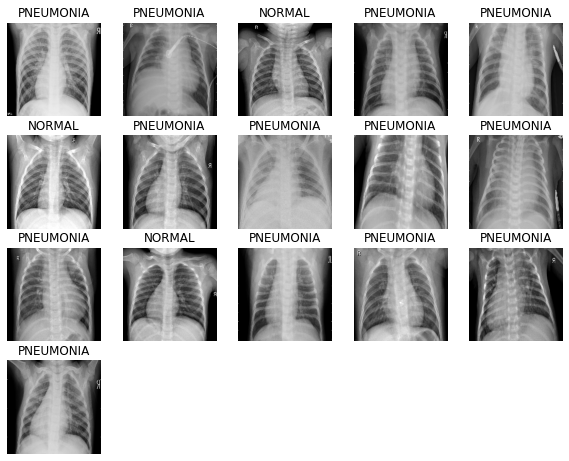

In [17]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(), ##
        tf.keras.layers.MaxPool2D() ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(dropout_rate) ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.3),
        conv_block(64),
        tf.keras.layers.Dropout(0.3),
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        conv_block(512),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(256, 0.5),
        dense_block(128, 0.4),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# Step 6. 모델 훈련

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/29
130/130 [==============================] - 37s 284ms/step - loss: 0.5184 - accuracy: 0.7558 - precision: 0.8523 - recall: 0.8102 - val_loss: 0.5775 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/29
130/130 [==============================] - 32s 244ms/step - loss: 0.2956 - accuracy: 0.8798 - precision: 0.9784 - recall: 0.8561 - val_loss: 0.6143 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 3/29
130/130 [==============================] - 29s 221ms/step - loss: 0.2277 - accuracy: 0.9046 - precision: 0.9758 - recall: 0.8930 - val_loss: 0.6386 - val_accuracy: 0.7520 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 4/29
130/130 [==============================] - 36s 274ms/step - loss: 0.1959 - accuracy: 0.9178 - precision: 0.9824 - recall: 0.9050 - val_loss: 0.6028 - val_accuracy: 0.7549 - val_precision: 0.7549 - val_recall: 1.0000
Epoch 5/29
130/130 [==============================] - 32s 244ms/step - loss: 0.2093 - accura

# Step 7. 결과 확인과 시각화

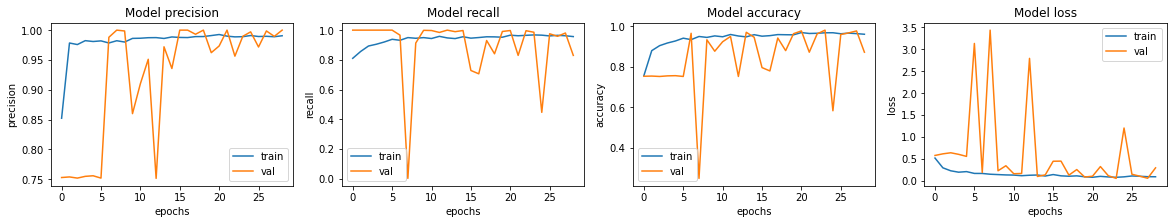

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 76s 4s/step - loss: 0.2949 - accuracy: 0.8862 - precision: 0.9059 - recall: 0.9128


# 회고

## * 이번 프로젝트에서 어려웠던 점.
    
    일단 분석하기 전에 dataset에 대해서 쭉 살펴보았습니다. 육안으로 봐도 폐렴인지 아닌지 구분하기 어려운 data가 존재하는 것을 확인하였습니다. model의 validation acc나 loss가 너무 튀는 현상이 잦아서 모델이 정확하게 학습하는 것인지에 대한 확신을 갖기가 어려웠습니다. 이 부분에 대해 확인해보기 위해 epoch를 100으로도 주고 모델의 성능을 측정해봤지만, 단순히 epoch를 많이 주는 것만으로는 크게 나아지지 않는 것을 확인하였습니다.

## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    
    deepML 시간에도 BatchNormalization과 Dropout 층의 공존에 대해서 배운 적이 있습니다. 노드에서도 약간의 힌트(?)식으로 언급되어있어서 이 부분에 대해 수정해보았지만, 모델의 학습 과정 중에서 validation sete에 대한 acc와 loss가 눈에 띄게 위아래로 튀는 현상에 대해서는 정확하게 잡아내지 못했습니다. (개인적인 생각으로는 의료 데이터에 이상치가 존재해 학습이 어느정도는 이루어지지만, 100% 완벽한 학습을 하기에는 좀 어려운 것이 아닌가 싶었습니다.)

## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
1) 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었는가? (모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.)
    
    Yes. 학습 그래프를 보면 위아래로 튀긴 하지만 전체적으로 loss의 경우 0을 향해가고 acc의 경우 100을 향해 가는 것을 확인할 수 있습니다.

2) 데이터 준비, 모델 구성 등의 과정의 다양한 실험이 체계적으로 수행되었는가? (regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 abalation study 형태로 체계적으로 수행되었다.)

    Yes. 노드에 나온 augmentation 기법과 더불어 모델의 layer추가, Batch Normalization과 Dropout과의 공존에 대한 고민, Dropout 파라미터 값 수정 등을 통해서 여러 방면으로 모델의 성능을 측정해보았습니다. 최종 제출본의 경우 정확도 0.85 이상의 결과물을 제출해야하기에 하나의 모델만 수행한 ipynb 파일을 제출하지만, 다른 백업 파일을 수정하여 위의 항목들에 대한 실습을 진행하였습니다.

3) 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었는가? (Accuracy 기준 85%에 도달하였다.)
    
    Yes. 0.88의 Accuracy를 확보하였습니다.